# GNN based property prediction

In this tutorial, we will explain the basic concepts of graph neural networks (GNNs). We will implement two simple GNNs for property prediction. 

**TODO List** 

* papers for application of GNNs
* quiz
* add more plots to compare gin and gcn
* add random seed
* reduce number of epochs
* run both gin and gcn 

### Content in Theory

* GNN Tasks
* Message Passing 
* Graph Convolutional Network (GCN)
* Graph Isomorphism Network (GIN)
* Training a GNN


### Content in Practical 

* Dataset 
* Defining a GCN and GIN
* Training a GNN
* Evaluating the model 

### References

* Papers: 
    * Geometric Deep Learning on Molecular Representations, [https://arxiv.org/pdf/2107.12375.pdf](https://arxiv.org/pdf/2107.12375.pdf)
    * How Powerful are Graph Neural Networks?, [https://arxiv.org/abs/1810.00826v3](https://arxiv.org/abs/1810.00826v3)
    * Semi-supervised classification with graph convolutional networks, [https://arxiv.org/pdf/1609.02907.pdf](https://arxiv.org/pdf/1609.02907.pdf)

* Blog posts: 
    * Graph Convolutional Networks: Introduction to GNNs, [https://mlabonne.github.io/blog/intrognn/](https://mlabonne.github.io/blog/intrognn/)
    * GIN: How to Design the Most Powerful Graph Neural Network, [https://mlabonne.github.io/blog/gin/](https://mlabonne.github.io/blog/gin/)

## Theory

### Graph Neural Networks

If we work with molecules, one intuitive approach to apply deep learning to certain tasks is to make use of the graph-structure of molecules. Graph neural networks can directly work on given graphs. 

#### GNN Tasks

We can perform different tasks with a GNN such as: 

- graph-level prediction: we predict a specific property of the entire graph. This can be a classification task such as toxicity prediction or a regression task. In this tutorial, we will present be a regression task.
- node-level prediction: we predict a property of a specific node in the graph, e.g. the atomic number. 
- node prediction: we predict a new node in the graph, this is relevant for molecule generation to extend molecules by adding new atoms. 
- edge prediction: we predict a new edge in the graph, this is also important in molecule generation to generate potential bonds between the atoms


#### Message Passing

Given a graph $G=(V,E)$, $V$ describe the vertices or nodes. A node $v$ can have different features $v_i$, such as atomic number. The edge features $e_{ij}$ are usually the bond type. 


<p align="center">
<img src="images/simple-graph.png" alt="simple_graph" width="600"/>
</p>

Instead of MLP layers in standard neural networks, GNNs have message passing layers, where we collect information about the neighbors. For each node $v$, we look at the direct neighbors $N(v)$ and gather information (such as node features). Then all the information is aggregated, for example with summation. Then we update the node $v$ with the aggregated messages. If we perform this aggregation and combining, each node contains the information about the direct neighbors (1-hop). If we repeat this $n$ times, we aggregate information about the $n$ th closest neighbors ($n$ -hop). 

$$a_v^{(k)} = \text{aggregate}^{(k)} (\{ h_u^{(k-1)}: u \in N(v) \})$$

$$h_v^{(k)} = \text{combine}^{(k)} (h_v^{(k-1)}, a_v^{(k)})$$

where $h_v^{(k)}$ is the embedding of node $v$ at layer $k$, $N(v)$ are the neighbors of node $v$. 



<p align="center">
<img src="images/gnn_overview.png" alt="simple_graph" width="600"/>
</p>
<p align="center">
    <em> Image taken from [<a href="https://medium.com/stanford-cs224w/self-supervised-learning-for-graphs-963e03b9f809" target="_top">1</a>]
</em>
</p>




#### GCN 

One of the simplest GNN is a Graph Convolutional Network (GCN). For GCNs, we sum over all neighbors of node $v$, including the node $v$ itself and aggregate all information. We divide it by the degree to keep the range of different nodes comparable. The node-wise aggregation function is

$$h_v = \Theta^{\top} \sum_{u \in N(v) \cup \{v\}} \frac{1}{\sqrt{d_v d_u}} \cdot h_u$$

where $d_j$ and $d_i$ denote the degree of node $j$ and $i$, respectively. 

One disadvantage of GCNs is, that they use a mean based aggregation and this function is not injective. This means that different graphs can lead to the same graph embedding and the network cannot distinguish between the two graphs anymore. One example is in the figure below. 


<p align="center">
<img src="images/graph.jpeg" alt="simple_graph" width="500"/>
</p>
<p align="center">
    <em> Two indistinguishable graphs using GCNs 
</em>
</p>


#### GIN 
For a GNN, we therefore need an aggregation function and a combining function that should be permutation invariant, such as using the mean, the maximum or a sum. In this tutorial, we focus on the Graph Isomorphism Network (GIN), where the aggregation function is defined as the following: 

$$h_v^{(k)} = h_\Theta((1+ \epsilon) \cdot h_v^{(k-1)} + \sum_{u \in N(v)} h_u^{(k-1)} )$$

The aggregation function here is a sum. The parameter $\epsilon$ decides on the importance of the node $v$ compared to its neighbors. $h_\Theta$ represents a neural network, for example an MLP. 


GINs are a good example of a simple network, which still is quite powerful, as they are quite good in distinguishing between non-isomorphic graphs. Two graphs are isomorphic, if the graphs are identical except for node permutations. While this might be easily visible for smaller graphs, it is a complex problem for larger graphs. When working with GNNs, we would like the model to give us the same output if the input graphs are isomorphic. On the other hand, we also want the model to be able to differentiate between non-isomorphic graphs and output (possibly) different results. GINs can differentiate between non-isomorphic graphs a lot better than other simple GNNs such as GCN and GraphSage. For example, the two graphs in the figure above have different embeddings using GINs, since we are using a sum-based aggregation. It is proven that GINs are as powerful as the Weisfeiler-Lehman test, a common (but not perfect) isomorphism test for graphs. If you are interested in the WL test or more details on GINs, [here](https://arxiv.org/abs/1810.00826v3) is the original publication about GINs and a [blog post](https://towardsdatascience.com/expressive-power-of-graph-neural-networks-and-the-weisefeiler-lehman-test-b883db3c7c49) about the WL test. 



#### Training a GNN

Similar to training a standard neural network, different design choices and hyperparameters need to be decided on. We will shortly present some concepts commonly used in neural networks, which can also be used for GNNs. Loss functions and activation functions are already discussed in Tutorial 22 (TODO: add link). We also used the mean squared error loss as well as the ReLU activation function. 


##### Batching

It is common to do batching when training a GNN to improve performance. The batch size indicates how many samples from the training data are fed to the neural network before updating model parameters. Choosing the right batch size is a trade-off between computational cost and generalization. For larger batches, the model is updated fewer times and the training is a lot faster. Models using smaller batches can generalize better, meaning that the test error can be lower. Since this is not the only hyperparameter, choosing the batch size is also linked to the learning rate, the number of training epochs etc. For batching in GNNs, the adjacency matrices are stacked diagonally and the node features are concatenated. 


<p align="center">
<img src="images/batching-ex.png" alt="simple_graph" width="600"/>
</p>
<p align="center">
    <em>Batching in GNNs, image taken from [<a href="https://blog.dataiku.com/graph-neural-networks-part-three" target="_top">2</a>]
</em>
</p>


#### Pooling

Pooling layers help a neural network to reduce dimensionality. This makes the model more robust to variations. In graphs, global pooling layers can produce a graph embedding from the different node embeddings. There are different ways for pooling, the most common ones are: mean, max and sum. For the GCN, we use a global mean pooling layer and for the GIN we use a global sum pooling layer. 



#### Dropout

One common problem in deep learning tasks is overfitting. This usually means that the dataset used to train the neural network is too small. Applying an overfitted network to a different dataset then leads to a high error in prediction, since the model is fit too closely to the training data and does not generalize well enough. To reduce overfitting, one approach is to use dropout layers, which can lead to a better generalization of the model. During training, nodes are randomly dropped. The probability of dropping nodes is another hyperparameter to be fixed. In each iteration, the nodes (and the number of nodes) can therefore differ. This means we incorporate more noise and therefore force the neural network to generalize better. 



## Practical 

**TODO** not done yet 



### Dataset 
For this tutorial, we use the `QM9` dataset, which can be imported with `torch_geometric`. The dataset contains around $130,000$ small molecules with at most 9 heavy atoms. The dataset has 19 different regression tasks, we will only focus on one of the tasks, which is the prediction of the dipole moment $\mu$. 

In [544]:
import torch
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
import torch.nn.functional as Fun
import pandas as pd
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
import numpy 
from pathlib import Path 

In [ ]:
# specify local data path 
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [546]:
class GNN(torch.nn.Module): 
    """Graph Convolutional Network class

    Args:
        torch (_type_): _description_
    """
    
    def __init__(self): 
        super().__init__()
        self.conv1 = GCNConv(11, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)
        self.lin = torch.nn.Linear(128, 1)
    
    def forward(self, data): 
        e = data.edge_index
        x = data.x
        
        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = global_mean_pool(x, data.batch)  

        # x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [548]:

class GIN(torch.nn.Module):
    """Graph Isomorphism Network class

    Args:
        torch (_type_): _description_
    """
    
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(11, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):

        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h

In [549]:
# TODO: run gnn and gin to compare
# model = GNN()

model = GIN(dim_h=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss = torch.nn.MSELoss()

def training(loader): 
    """Training

    Args:
        loader (DataLoader): training data divided into batches

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader: 
        optimizer.zero_grad()
        d.x = d.x.float()
    
        out = model(d)
        
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss 

In [550]:
# load dataset

qm9 = QM9(root='')

y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0])

qm9 = qm9.shuffle()

# normalizing the data 
data_mean = qm9.data.y[0:20000].mean()
data_std = qm9.data.y[0:20000].std()

qm9.data.y = (qm9.data.y - data_mean) / data_std

train_loader = DataLoader(qm9[0:20000], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[20000:25000], batch_size=64, shuffle=True)



In [551]:
def test(loader): 
    """calculates validation loss

    Args:
        loader (DataLoader): validation set in batches

    Returns:
        float: validation loss
    """
    model.eval()
    test_loss = 0
    for d in loader: 
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1))) 
        test_loss += l / len(loader)
    return test_loss 

In [552]:
# function for plotting loss and accuracy 

def plot_hist2(hist):
    """plot test and validation loss for each epoch

    Args:
        hist (_type_): contains train and val losses
    """
    epochs, t_loss, t_acc, tpr, tnr, test_loss, test_acc = zip(*hist)
    plt.figure(figsize=(16, 6))
    plt.plot([1, 2])
    plt.subplot(121)
    plt.plot(epochs, t_acc, label="accuracy")
    plt.plot(epochs, test_acc, label=" val accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(epochs, t_loss, label="training loss")
    plt.plot(epochs, test_loss, label="val loss")
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [556]:
# plotting true vs predicted value 

def plot_targets(pred, ground_truth): 
    """plots true vs predicted value in scatter plot

    Args:
        pred (numpy.array): predicted values
        ground_truth (numpy.array): ground truth values
    """
    plt.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title("True vs predicted values")
    plt.show()

Epoch:0, Training loss: tensor(0.6844, grad_fn=<AddBackward0>), Test loss: tensor(0.6358, grad_fn=<AddBackward0>)
Epoch:10, Training loss: tensor(0.4359, grad_fn=<AddBackward0>), Test loss: tensor(0.4036, grad_fn=<AddBackward0>)
Epoch:20, Training loss: tensor(0.3897, grad_fn=<AddBackward0>), Test loss: tensor(0.4040, grad_fn=<AddBackward0>)
Epoch:30, Training loss: tensor(0.3634, grad_fn=<AddBackward0>), Test loss: tensor(0.3555, grad_fn=<AddBackward0>)
Epoch:40, Training loss: tensor(0.3460, grad_fn=<AddBackward0>), Test loss: tensor(0.3506, grad_fn=<AddBackward0>)
Epoch:50, Training loss: tensor(0.3368, grad_fn=<AddBackward0>), Test loss: tensor(0.3583, grad_fn=<AddBackward0>)
Epoch:60, Training loss: tensor(0.3172, grad_fn=<AddBackward0>), Test loss: tensor(0.3225, grad_fn=<AddBackward0>)
Epoch:70, Training loss: tensor(0.3089, grad_fn=<AddBackward0>), Test loss: tensor(0.3488, grad_fn=<AddBackward0>)
Epoch:80, Training loss: tensor(0.3021, grad_fn=<AddBackward0>), Test loss: tenso

/var/folders/9p/vmw7ktwj05v2jfcjtj798dcw0000gn/T/ipykernel_55472/1070871917.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


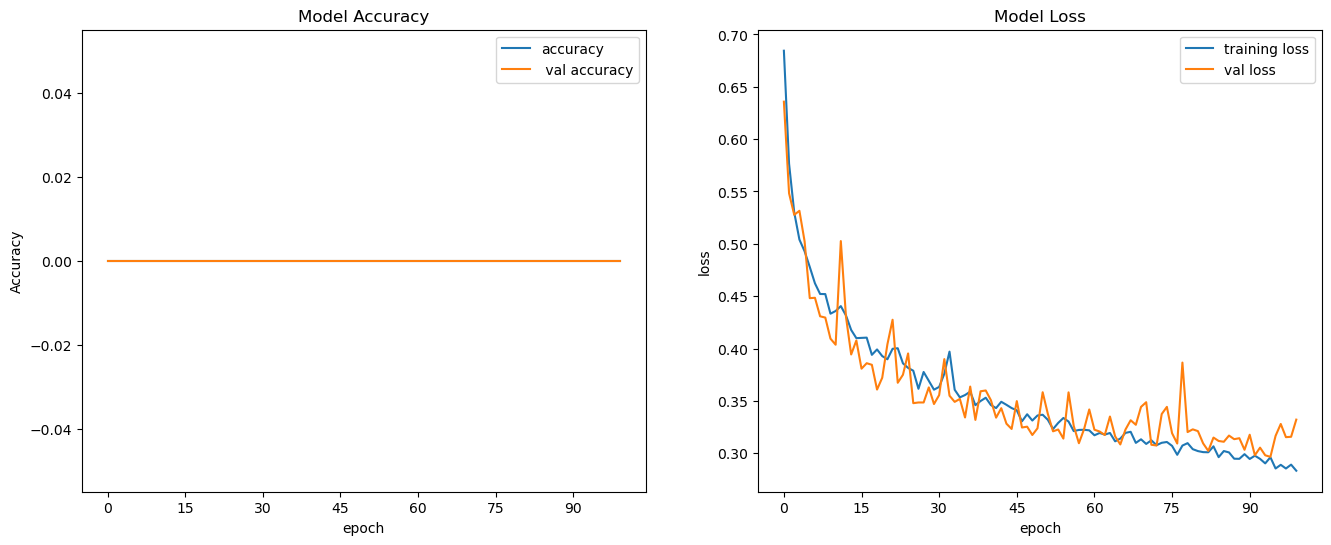

In [554]:
# calling the training

hist_data = []
train_target = numpy.empty((0))
train_y_target = numpy.empty((0))
test_target = []
for epoch in range(100): 
    epoch_loss = training(train_loader)
    #test_acc, test_loss = test(test_loader)
    test_loss = test(test_loader)
    correct = 0
    tpr = 0
    tnr = 0
    for d in train_loader: 
        out = model(d)
        if epoch == 99:
            # record true vs predicted values for training data 
            train_target = numpy.concatenate((train_target, out.detach().numpy()[:,0]))
            train_y_target = numpy.concatenate((train_y_target, d.y.detach().numpy()))
    
    hist_data.append([epoch, epoch_loss.detach().numpy(), 0, 0, 0, test_loss.detach().numpy(), 0])
    if epoch % 10 == 0: 
        print("Epoch:" + str(epoch) + ", Training loss: " + str(epoch_loss) + ", Test loss: " + str(test_loss))

plot_hist2(hist_data)

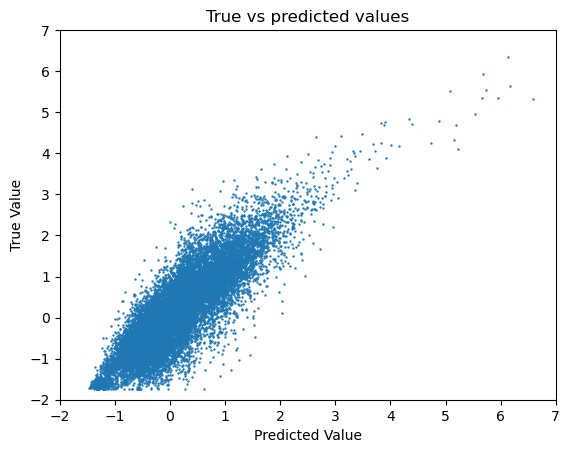

In [557]:
# plot target and prediction 

plot_targets(train_target, train_y_target)


/var/folders/9p/vmw7ktwj05v2jfcjtj798dcw0000gn/T/ipykernel_55472/1070871917.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


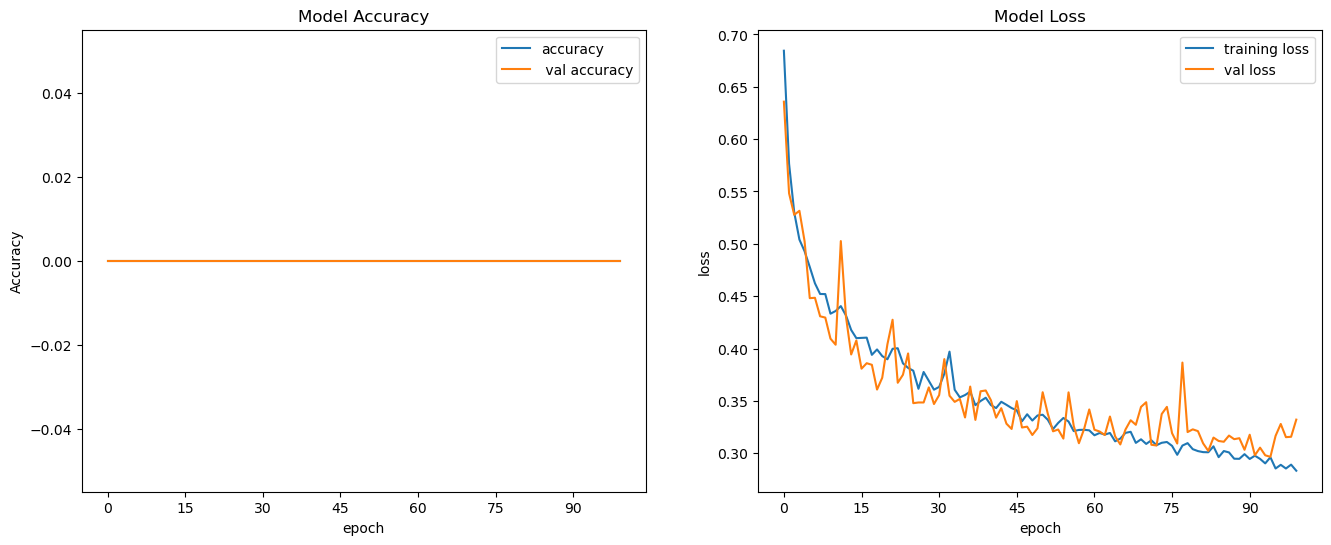

In [558]:
plot_hist2(hist_data)